>### The inspiration for this tutorial comes from my completion of the Deep Learning Specialization course on Coursera, and main compoents are taken from the course content.

To run the code, download the data from https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge, and create the following directoris </br>
- 'CAIS/data/U_NET_data/CameraRGB' </br>
- 'CAIS/data/U_NET_data/CameraMask'

# Image Segmentation with U-Net

>The term used to describe this type of image categorization is known as "semantic image segmentation". It bears similarities to object detection in the sense that both aim to answer the question: >"Which objects are present in the image and where are they located within the image?" However, while object detection labels objects using bounding boxes that may encompass pixels outside the >object, semantic image segmentation provides a precise mask for each object in the image by assigning a label to every pixel in the image. The term "semantic" is used to denote the content of the >image, such as the "Car" class represented by the dark blue mask, and the "Person" class represented by a red mask in the example below:

><img src="images/carseg.png" style="width:500px;height:250;">

>labeling that is specific to a region is an extremely important aspect for self-driving cars. These vehicles necessitate a meticulous comprehension of their surroundings, down to the pixel, to >execute actions such as changing lanes and evading other cars, as well as avoiding various traffic impediments that could potentially jeopardize human lives. 

>Objectives of this Toturial:
>
>* Design a U-Net
>* Implement semantic image segmentation on the CARLA self-driving car dataset (23 classes)
>* Apply sparse categorical crossentropy for pixelwise prediction

In [1]:
import tensorflow as tf
import os
import imageio
from pyprojroot import here
import matplotlib.pyplot as plt
%matplotlib inline


### Load and Split the Data

In [2]:
image_path = os.path.join(here(), 'data/U_NET_data/CameraRGB/')
mask_path = os.path.join(here(), 'data/U_NET_data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:
**ATTENTION: After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.**

C:\Users\farza\AppData\Local\Temp\ipykernel_19272\2127741555.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\farza\AppData\Local\Temp\ipykernel_19272\2127741555.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

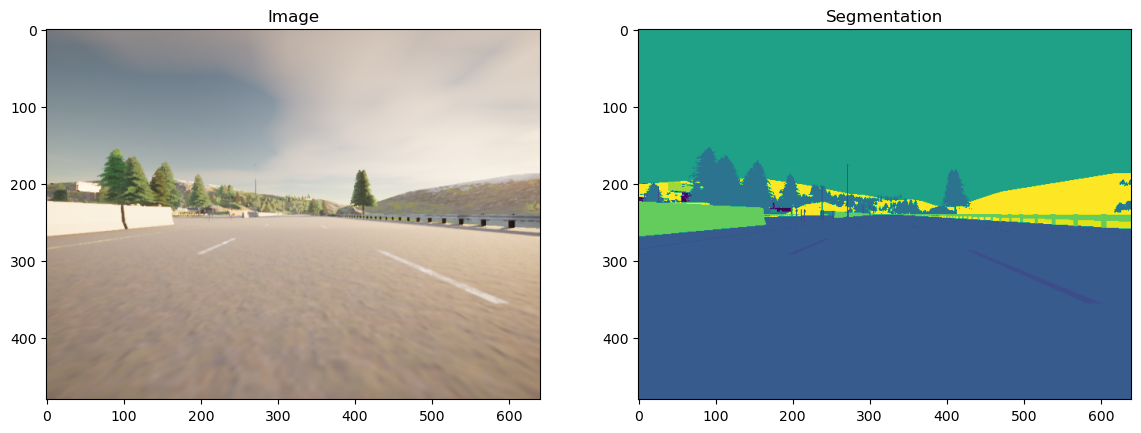

In [3]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'f:\\Github\\CAIS\\data\\U_NET_data\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'f:\\Github\\CAIS\\data\\U_NET_data\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'f:\\Github\\CAIS\\data\\U_NET_data\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'f:\\Github\\CAIS\\data\\U_NET_data\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'f:\\Github\\CAIS\\data\\U_NET_data\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'f:\\Github\\CAIS\\data\\U_NET_data\\CameraMask\\000028.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'f:\\Github\\CAIS\\data/U_NET_data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'f:\\Github\\CAIS\\data/U_NET_data/CameraMask/000026.png', shape=(), dtype=string)


### Preprocess Your Data

In [6]:
def process_path(image_path, mask_path):
    """
    It uses TensorFlow's tf.io.read_file method to read the image and mask files from their respective paths.
    The image and mask are then decoded using tf.image.decode_png with 3 channels. The image is converted to
    a float32 data type using tf.image.convert_image_dtype. The mask is processed by taking the maximum value
    of the pixel values along the last axis (which represents the channels) and keeping the dimensions intact.
    Finally, the processed image and mask are returned as a tuple.
    
    Arguments:
    image_path:str, mask_path:str 
    Returns:
    the processed image and mask
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    """
    It resizes the image and mask using TensorFlow's tf.image.resize method to a fixed size of
    (96, 128) using the nearest neighbor interpolation method. The resized image is then normalized
    by dividing each pixel value by 255. The preprocessed image and mask are returned as a tuple.
    """
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

### U-Net 

>U-Net derives its name from its U-shaped design and was initially developed in 2015 for detecting tumors. Over time, it has become a highly popular option for other semantic segmentation tasks.
>
>The U-Net architecture is an extension of the Fully Convolutional Network (FCN), which replaces the dense layers typically found in a Convolutional Neural Network (CNN) with a transposed convolution >layer. The transposed convolution layer upsamples the feature map to match the original input image's size while preserving its spatial information. Spatial information is critical for image >segmentation tasks, and dense layers tend to destroy it. The use of transpose convolutions also makes the input size flexible, unlike with dense layers, which require a fixed size.
>
>However, the final feature layer of the FCN suffers from information loss due to excessive downsampling. The information loss makes it challenging to upsample the feature maps, resulting in an >output that appears rough.
>
>U-Net enhances the FCN's design by incorporating some crucial modifications. Rather than having a single transposed convolution layer at the end of the network, U-Net uses an equivalent number of >convolution layers for downsampling the input image to a feature map. It also incorporates transposed convolutions to upsample the feature maps back up to the original input image size. >Additionally, U-Net employs skip connections to retain the information that would otherwise be lost during encoding. The skip connections transmit information from each downsampling layer in the >encoder to the corresponding upsampling layer in the decoder. This approach captures finer information while keeping computation low, thus preventing information loss and model overfitting.

### Model Details

<img src="images/unet.png" style="width:700px;height:400;">

>**Contracting path** (Encoder containing downsampling steps):</br>
>To extract features from input images, U-Net employs a contracting path, also known as the encoder. This path consists of several convolutional layers that decrease the height and width of the input >image while increasing the number of channels.

>The contracting path is composed of a standard CNN architecture that includes convolutional layers, their activations, and pooling layers to downsample the image and extract its features. >Specifically, it consists of multiple repetitions of two unpadded 3 x 3 convolutions, followed by a rectified linear unit (ReLU) activation function and a 2 x 2 max pooling operation with stride 2 >for downsampling. Each downsampling step doubles the number of feature channels.

>**Crop function**: </br>
>To create skip connections that retain high-resolution information, the contracting path's output is cropped and concatenated to the expanding path's input.

>**Expanding path** (Decoder containing upsampling steps): </br>
>The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually. </br>
>
>In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, >while growing the height and width of the image. </br>
>
>Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss >of border pixels in every convolution.

>**Final Feature Mapping Block**: </br>
>In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of >filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the >channel dimensions to have one layer per class. 

>The U-Net network has 23 convolutional layers in total. 

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">

>The encoder is a stack of various conv_blocks:

>Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks specifically to the last two blocks of the >downsampling. 

>The function will  return two tensors: 
>- `next_layer`: That will go into the next block. 
>- `skip_connection`: That will go into the corresponding decoding block.

>**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, >depending on the case). Else, both results will be identical.  

In [7]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    
    conv = tf.keras.layers.Conv2D(n_filters, 
                  3,    # Kernel size
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(inputs)
    conv = tf.keras.layers.Conv2D(n_filters, 
                  3,   # Kernel size
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### Decoder (Upsampling Block)

>The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it >before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">

>There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 
>
>Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer.

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = tf.keras.layers.Conv2DTranspose(
                 n_filters,    
                 3,   # Kernel size 
                 strides = (2, 2),
                 padding = 'same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)
    conv = tf.keras.layers.Conv2D(n_filters,   
                  3,     # Kernel size
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(merge)
    conv = tf.keras.layers.Conv2D(n_filters,
                  3,   # Kernel size
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    
    return conv


### Build the Model

the number of output channels for this particular cas is 23 since there are 23 possible labels for each pixel in this self-driving car dataset. 

>The first half of the model follows the following steps:
>
>Start with a conv block that takes the model inputs and specifies the number of filters.</br>
>Chain the first output element of each block to the input of the next convolutional block.</br>
>Double the number of filters at each step.</br>
>Add dropout of 0.3 starting from conv_block4.</br>
>For the final conv_block, set dropout to 0.3 again and turn off max pooling.</br>

>The second half of the model follows these steps:
>
>Use cblock5 as the expansive input and cblock4 as the contractive input with n_filters * 8. This is the bottleneck layer.</br>
>Chain the output of the previous block as expansive input and the corresponding contractive block output.</br>
>Note that the second element of the contractive block before the max pooling layer must be used.</br>
>At each step, use half the number of filters of the previous block.</br>
>conv9 is a Conv2D layer with ReLU activation, He normal initializer, and "same" padding.</br>
>Finally, conv10 is a Conv2D layer with the number of classes as the filter, a kernel size of 1, and "same" padding. The output of conv10 represents the output of the model.</br>

In [9]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = tf.keras.layers.Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=None) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = tf.keras.layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = tf.keras.layers.Conv2D(n_classes, 1, padding = 'same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

### Build and compile the model:
>To perform semantic segmentation, a mask is required for each object class. The dataset being used assigns a single integer probability, ranging from 0 to num_classes-1, to every pixel in each mask >to indicate the likelihood of it belonging to a certain class. The correct class is determined by identifying the layer with the highest probability.
>
>Unlike categorical crossentropy, where the labels are one-hot encoded with 0s and 1s, the loss function used in this case is sparse categorical crossentropy. This is because pixel-wise multiclass >prediction is performed, and sparse categorical crossentropy is more efficient than other loss functions when working with a large number of classes.

In [10]:
img_height = 96
img_width = 128
num_channels = 3
unet = unet_model((img_height, img_width, num_channels))
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

>his function enables the display of both an input image and its corresponding ground truth, which represents the actual mask. The objective of the trained model is to produce an output that is as similar as possible to this ground truth mask.

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


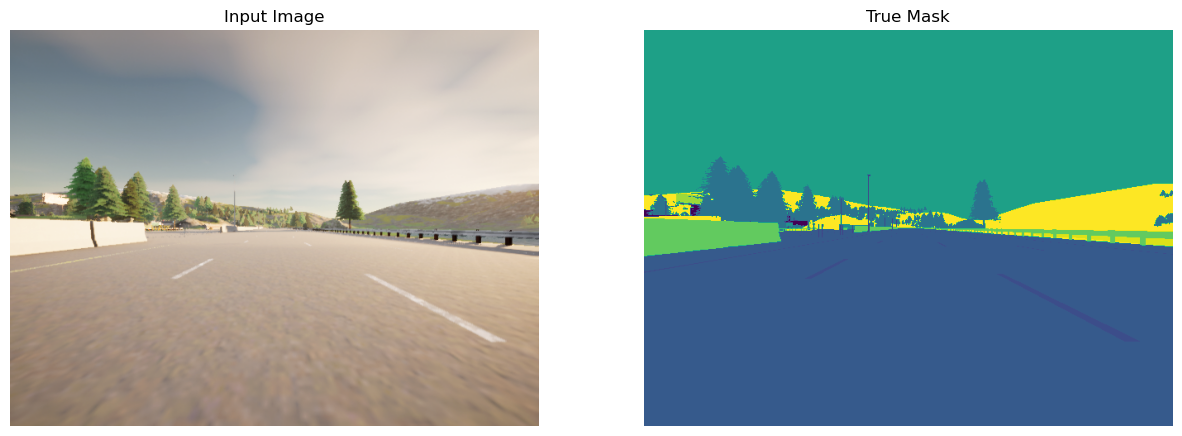

In [12]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


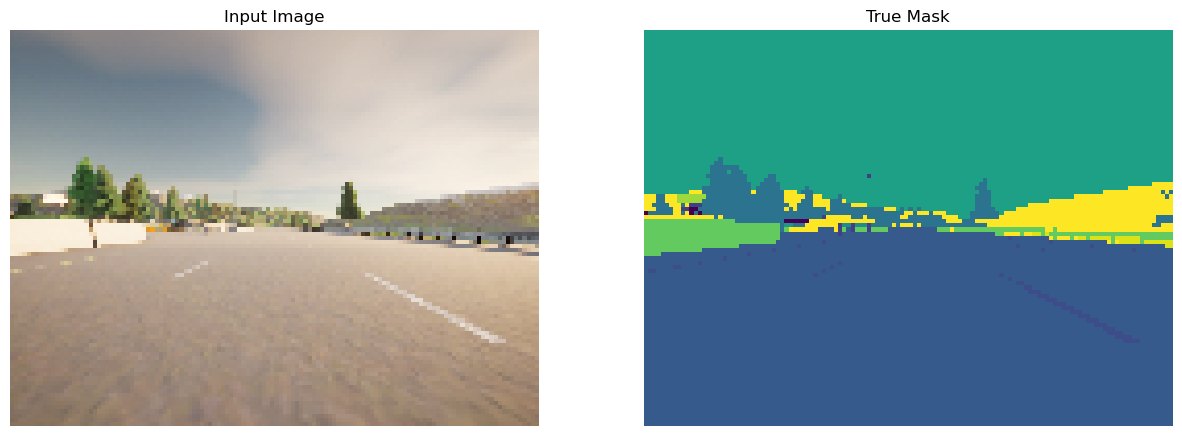

In [13]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])


### Train the Model and check its performance of the training data

(In This example, we don't have validation and test set since this demonstration serves purely as an illustrative example )

In [36]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS, verbose=0)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


In [37]:
unet.evaluate(train_dataset, batch_size=BATCH_SIZE)

1/1 [==============================] - 0s 55ms/step - loss: 0.1102 - accuracy: 0.9603


[0.11015001684427261, 0.9603291153907776]

### Model Accuracy

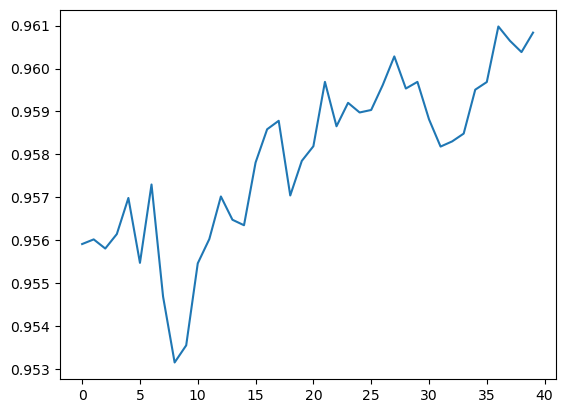

In [38]:
plt.plot(model_history.history["accuracy"])

### Let's see the performance of the model

In [39]:
def create_mask(pred_mask):
    """
    This function uses `tf.argmax` in the axis of the number of classes to return 
    the index with the largest value and merge the prediction into a single image .
    """
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

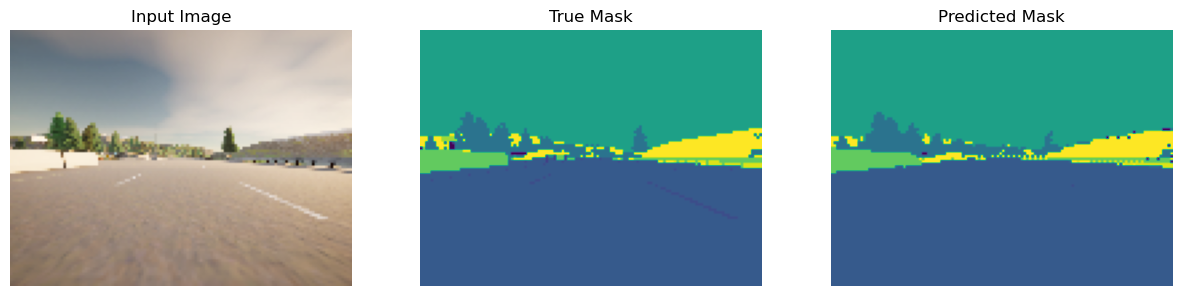

In [40]:
show_predictions(train_dataset, 6)